# **Figure ?.** Diffusion Coefficient
| Author  | Stanley A. Baronett |
|---------|---------------------|
| Created | 01/31/2022          |
| Updated | 09/26/2022          |

## $D$, $H_\mathrm{p}$ vs. $\Pi$
See Yang et al. (2009), § 4.1, for CC's derivation of the diffusion coefficient, $D$.

From Eq. 9 of Yang & Zhu (2021),
\begin{equation}
  H_\mathrm{p} \approx \sqrt{\frac{D_z}{\Omega_\mathrm{K}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)} = H_\mathrm{g}\sqrt{\frac{D_z}{c_\mathrm{s}H_\mathrm{g}}\left(\tau_\mathrm{s} + \frac{1}{\tau_\mathrm{s}}\right)},
\end{equation}
where $(\tau_\mathrm{s} + \tau_\mathrm{s}^{-1})/\Omega_\mathrm{K}$ is the sedimentation time-scale (Youdin & Lithwick 2007).

### Units

Our *length* $[\sf{L}]$ and *time* $[\sf{T}]$ [code units](https://github.com/sabaronett/streaming-instability/blob/main/ipynb/ref/CodeUnits.ipynb) in Athena++ are the vertical gas scale height $H = c_\mathrm{s}/\Omega = 1$ and orbital period $T = 2\pi/\Omega = 1$, respectively.
Accordingly, we set the speed of sound and angular frequency of our shearing box as $ c_\mathrm{s} = \Omega = 2\pi$ in our Athena++ input file `athinput.si`.
With these, we can convert the diffusion coefficient's $D [H^2/T]$ units that we measure natively to more standard $[c_\mathrm{s}H]$ units as follows:
\begin{align*}
    \frac{D}{H^2/T} = \frac{D}{H}\frac{T}{H} &= \frac{D}{H}\frac{2\pi}{\Omega}\frac{\Omega}{c_\mathrm{s}} = \frac{D}{H}\frac{2\pi}{c_\mathrm{s}} \\
    \frac{D}{c_\mathrm{s}H} &= \frac{1}{2\pi}\frac{D}{H^2/T}
\end{align*}

,Case,Function,a,±𝜎ₐ,k,±𝜎ₖ
0,AB,𝐷_z = aΠᵏ,5.3e-03,±1.5e-04,1.8e+00,±1.2e-02
1,AB,𝐷_x = aΠᵏ,1.4e-02,±7.3e-04,2.0e+00,±2.2e-02
2,BA,𝐷_z = aΠᵏ,2.0e-02,±7.9e-03,5.8e-01,±1.4e-01
3,BA,𝐷_x = aΠᵏ,4.9e-02,±8.6e-03,1.2e+00,±7.2e-02


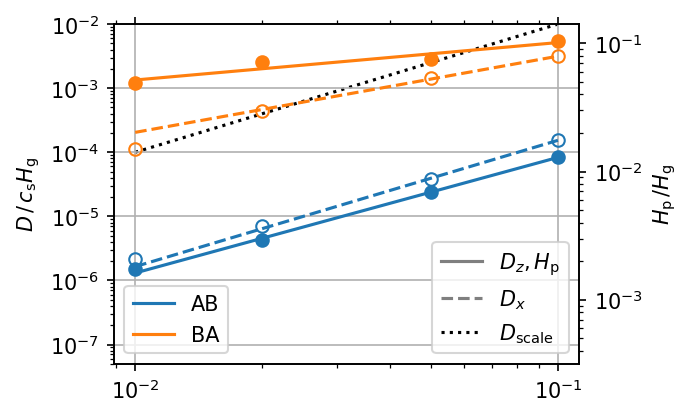

In [4]:
import sys
sys.path.insert(0, '/home/stanley/bitbucket/ccyang/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

workdir = '../unstrat'
cases = [['AB', 'tab:blue'], ['BA', 'tab:orange']]
Pis = [0.01, 0.02, 0.05, 0.10]
res = '2048'
dirs = [['z', 'dpy', 'full', 'solid'],
        ['x', 'dpx', 'none', 'dashed']]
Ds = np.zeros((len(Pis), len(dirs)))
plaw = lambda Pi, a, k : a*Pi**k # Power-law model function
group, modplaw, a, aerr, k, kerr = [], [], [], [], [], []
xfit = np.linspace(0.01, 0.1)
fig, ax1 = plt.subplots(figsize=(4, 3), dpi=150)
ax2 = ax1.twinx()
y1l, y2l = 5e-8, 1e-2

for case in cases:
    ax2.plot([], [], color=case[1], label=case[0])

    for i, dir in enumerate(dirs):
        for j, Pi in enumerate(Pis):
            # Collect sim parameters, diffusion coefficients, dust scale heights
            path = f'{workdir}/{case[0]}/{Pi:.2f}/{res}'
            athinput = athena_read.athinput(f'{path}/athinput.si')
            c_s = athinput['hydro']['iso_sound_speed']
            Omega = athinput['problem']['omega']
            Hg = c_s/Omega
            tau_s= athinput['particles']['taus0']*Omega
            if case[0] == 'AB' and Pi == 0.01:
                D = np.load(f'{path}/output/dcoeff-61.npz')
            else: D = np.load(f'{path}/output/dcoeff-81.npz')
            Ds[j, i] = D[dir[1]][0]/c_s # convert to [c_s*Hg]

        # Best-fit and plot diffusion coefficients
        popt, pcov = curve_fit(plaw, Pis, Ds[:, i])
        perr = np.sqrt(np.diag(pcov))
        yfit = plaw(xfit, *popt)
        ax1.plot(Pis, Ds[:, i], marker='o', ls='none', color=case[1],
                fillstyle=dir[2])
        ax1.plot(xfit, yfit, ls=dir[3], color=case[1])
        group.append(case[0]); modplaw.append(f'𝐷_{dir[0]} = aΠᵏ')
        a.append(popt[0]); aerr.append(perr[0])
        k.append(popt[1]); kerr.append(perr[1])

# Format plot with line styles legend
ax1.plot([], [], ls=dirs[0][3], color='tab:gray',
         label=f'$D_{dirs[0][0]}, H_\mathrm{{p}}$')
ax1.plot([], [], ls=dirs[1][3], color='tab:gray', label=f'$D_{dirs[1][0]}$')
ax1.plot(xfit, plaw(xfit, 1, 2), ls=':', color='black', zorder=-1,
         label=r'$D_\mathrm{scale}$') # = Pi^2
ax1.grid()
ax1.minorticks_on()
ax1.tick_params(which='both', top=True)
ax1.legend(loc='lower right')
ax1.set(ylabel=r'$D\,/\,c_\mathrm{s}H_\mathrm{g}$', xscale='log',
        yscale='log', ylim=(y1l, y2l))

# Set dust scale height limits and format right axis (twinx)
Hp = lambda D_z, tau_s: np.sqrt(D_z*(tau_s + 1/tau_s))
y1r, y2r = Hp(y1l, tau_s), Hp(y2l, tau_s)
ax2.minorticks_on()
ax2.legend(loc='lower left')
ax2.set(ylabel=r'$H_\mathrm{p}\,/H_\mathrm{g}$', yscale='log', ylim=(y1r, y2r))

plt.savefig('figs/diffusion.pdf', bbox_inches='tight', pad_inches=0.01)

df = pd.DataFrame({
    'Case'     : group,
    'Function' : modplaw,
    'a'        : a,
    '±𝜎ₐ'      : aerr,
    'k'        : k,
    '±𝜎ₖ'      : kerr,})
s = df.style.format({
    'a'   : '{:.1e}',
    '±𝜎ₐ' : '±{:.1e}',
    'k'   : '{:.1e}',
    '±𝜎ₖ' : '±{:.1e}',})
s.to_latex(buf='tabs/diffusion.sty')
s

### Dimensional analysis
- $D_\mathrm{scale} = \Pi^2c_\mathrm{s}H_\mathrm{g}$
- for AB, smaller than expected
  - turbulent eddy scale is smaller than $\Pi H$
  - turbulent velocity smaller than $\Pi c_\mathrm{s}$
- BA is NOT turbulence
  - Exceeds scaling argument
  - Power law index less than 2
